# Глубинное обучение для текстовых данных, ФКН ВШЭ

## Домашнее задание 3: Генеративные языковые модели или как написать научную статью

### Оценивание и штрафы

Максимально допустимая оценка за работу — 13 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Весь код должен быть написан самостоятельно. Чужим кодом пользоваться запрещается даже с указанием ссылки на источник. В разумных рамках, конечно. Взять пару очевидных строчек кода для реализации какого-то небольшого функционала можно.

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### Задание 0

В данной работе мы реализуем несколько языковых моделей генерации текста на основе архитектур CNN, RNN и Transformer. И сравним их между собой. Реализацию CNN и RNN разрешается брать из прошлых дз.

Данная работа во многом повторяет логику аналогичной работы из ШАД: https://github.com/yandexdataschool/nlp_course/blob/2022/week03_lm/homework_pytorch.ipynb

Все модели нужно будет реализовывать на pytorch (считать градиенты руками не надо). При обучении разных моделей используйте одинаковые параметры оптимизатора, базмер батча, а так же учите либо одинаковое число эпох, либо до сходимости. В общем, постарайтесь, чтобы сравнение всегда было максимально честным.

__Мягкий дедлайн: 30.11.23 23:59__

__Жесткий дедлайн: 04.12.23 23:59__

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict

[Будем использовать датасет научных статей.](https://www.kaggle.com/neelshah18/arxivdataset/)

In [ ]:
data = pd.read_json("./arxivData.json")
data.sample(n=1)

,author,day,id,link,month,summary,tag,title,year
3295,"[{'name': 'Jan Reininghaus'}, {'name': 'Stefan...",21,1412.6821v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",12,Topological data analysis offers a rich source...,"[{'term': 'stat.ML', 'scheme': 'http://arxiv.o...",A Stable Multi-Scale Kernel for Topological Ma...,2014


Оставим только поля title и summary

In [ ]:
lines = data.apply(lambda row: row['title'] + ' ; ' +
                   row['summary'].replace('\n', ' '), axis=1).tolist()
lines[:1]

['Dual Recurrent Attention Units for Visual Question Answering ; We propose an architecture for VQA which utilizes recurrent layers to generate visual and textual attention. The memory characteristic of the proposed recurrent attention units offers a rich joint embedding of visual and textual features and enables the model to reason relations between several parts of the image and question. Our single model outperforms the first place winner on the VQA 1.0 dataset, performs within margin to the current state-of-the-art ensemble model. We also experiment with replacing attention mechanisms in other state-of-the-art models with our implementation and show increased accuracy. In both cases, our recurrent attention mechanism improves performance in tasks requiring sequential or relational reasoning on the VQA dataset.']

## Токенизация

In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import BPE

In [ ]:
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))

Мы можем задать аргументы, такие как vocab_size или min_frequency, но самая важная часть - это указать special_tokens, которые мы планируем использовать позже (они вообще не используются во время обучения), чтобы они были вставлены в словарь.

 Еще один важный параметр, который улучшит качество обученной модели, это базовый словарь. Базовый словарь, включающий все возможные базовые символы, может быть довольно большим, если, например, все символы юникода рассматриваются как базовые символы. Чтобы иметь лучший базовый словарный запас, GPT-2 использует байты в качестве базового словарного запаса, что является хитрым трюком, позволяющим заставить базовый словарный запас иметь размер 256, гарантируя при этом, что каждый базовый символ включен в словарный запас.

In [ ]:
base_vocab = [chr(n) for n in range(32, 79)]
vocab_size = 30000

In [ ]:
from tokenizers.trainers import BpeTrainer

In [ ]:
trainer = BpeTrainer(
    special_tokens=["[UNK]", "[BOS]", "[EOS]"],
    vocab_size=vocab_size,
    initial_alphabet=base_vocab,
)

Мы могли бы обучить наш токенизатор прямо сейчас, но это было бы неоптимально. Без предварительного токенизатора, который разделит наши входные данные на слова, мы могли бы получить токены, которые перекрывают несколько слов: например, мы могли бы получить токен "it is", поскольку эти два слова часто появляются рядом друг с другом. Использование предварительного токенизатора гарантирует, что ни один токен не будет больше слова, возвращаемого предварительным токенизатором. Здесь мы хотим обучить токенизатор BPE, и мы будем использовать самый простой из возможных претокенизаторов.

In [ ]:
from tokenizers.pre_tokenizers import Whitespace
tokenizer.pre_tokenizer = Whitespace()

In [ ]:
from tokenizers.processors import TemplateProcessing
tokenizer.post_processor = TemplateProcessing(
    single="[BOS] $A [EOS]",
    special_tokens=[("[BOS]", 1), ("[EOS]", 2)],
)

In [ ]:
tokenizer.train_from_iterator(lines, trainer)

In [ ]:
tokenizer.save("tokenizer-arxiv.json")

In [ ]:
tokenizer = Tokenizer.from_file("tokenizer-arxiv.json")

In [ ]:
tokenizer.encode("Hello, y'all! How are you 😁 ?").ids

[1, 16166, 194, 15, 92, 10, 343, 4, 4331, 211, 8761, 0, 34, 2]

## Датасет

__Задание 1 (1 балл)__
Здесь мы напишем класс датасета, который будем использовать в дальнейшем при обучении. Дополните класс методом tokenize_data, чтобы токенизировать данные заранее и не тратить на это время при обучении.

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch

In [ ]:
max_length = 256
batch_size = 2

data_train, data_valid = train_test_split(
    lines, test_size=0.01, shuffle=True, random_state=0
)

In [ ]:
class Dataset:
    def __init__(self, data: List[str], tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.pad_token = "[EOS]"
        self.pad_id = tokenizer.token_to_id(self.pad_token)
        self.max_length = max_length
        self.tokenized_data, self.mask_data = self.tokenize_data()

    def __len__(self,):
        return len(self.data)

    def tokenize_data(self,) -> Tuple[List[List[int]], List[List[int]]]:
        """
        Tokenize all sequences in self.data, don't forget about padding and max_length

        :return
            tokenized data, masks of padding tokens. 0 should be after first EOS, not including

        :hints look at encode, enable_padding, enable_truncation methods of tokenizer
        """
        self.tokenizer.enable_padding(pad_token=self.pad_token, pad_id=self.pad_id, length=self.max_length)
        self.tokenizer.enable_truncation(max_length=self.max_length)

        encodings = [self.tokenizer.encode(str) for str in self.data]
        tokenized_data, mask_data = [e.ids for e in encodings], [e.attention_mask for e in encodings]

        return tokenized_data, mask_data

    def __getitem__(self, idx):
        """
        :params
            idx: the index of dataset element

        Don't forget to use torch.tensor
        """
        return {
            "input_ids": torch.tensor(self.tokenized_data[idx]),
            "mask": torch.tensor(self.mask_data[idx])
        }

In [ ]:
dataset_train = Dataset(data_train, tokenizer, max_length)
dataset_valid = Dataset(data_valid, tokenizer, max_length)

In [ ]:
train_loader = DataLoader(
    dataset=dataset_train,
    batch_size=batch_size,
    shuffle=True,
)

valid_loader = DataLoader(
    dataset=dataset_valid,
    batch_size=batch_size,
    shuffle=False,
)

## Языковые модели

Запишем вероятностную модель, которой будем оценивать правдоподобие текстов:

$$P(X) = P(x_0, \dots, x_{t-1}, x_{t}) = \prod_t P(x_t \mid x_0, \dots, x_{t-1})$$

Давайте учить модель, которая будет предсказывать вероятность следующего слова по всем предыдущим, то есть другими словами приближать следующую вероятность:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$

### Языковая модель с фиксированным окном

__Задание 2 (1 балл)__
Осталось понять, как задать модель, которая будет оценивать данную вероятность. После бума сверточных нейронных сетей их начали пытаться применять к генерации текстов. У данной архитектуры есть очевидны минус - фиксированное окно или "ограниченная память". То есть другими словами, сверточные сети могут эффективно смотреть только на фиксированное количество предыдущих слов. Но в то же время эти модели очень быстрые. Давайте реализуем сверточную нейронную сеть и справним ее с другими архитектурами.

In [ ]:
def number_of_weights(nn):
    return sum(p.numel() for p in nn.parameters() if p.requires_grad)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

In [ ]:
class FixedWindowLanguageModel(nn.Module):
    def __init__(self, vocab_size, words_count, emb_size=16, hidden_size=32, window_size=5):
        """
        A fixed window model that looks on at least 5 previous symbols.

        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}
        - If you're absolutely lost, here's a hint: use nn.ZeroPad2d((NUM_LEADING_ZEROS, 0, 0, 0))
          followed by a nn.Conv1d(..., padding=0). And yes, its okay that padding is technically "2d".

        :param
            vocab_size: the size of tokenizer vocabulary
            emb_size: the size of embedding layer
            hidden_size: the size of vectors inside neural network
            window_size: the context length

        """
        super().__init__()  # initialize base class to track sub-layers, trainable variables, etc.
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb2hidden = nn.Linear(in_features=emb_size, out_features=hidden_size)
        self.first = nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size * 2, kernel_size=window_size, padding=window_size//2,stride=2)
        self.second = nn.Conv1d(in_channels=hidden_size * 2, out_channels=hidden_size // 2, kernel_size=window_size, padding=window_size//2, stride=2)
        self.third = nn.Conv1d(in_channels=hidden_size // 2, out_channels=1, kernel_size=window_size, padding=window_size//2, stride=2)
        self.fc = nn.Linear(in_features=words_count // 8, out_features=vocab_size)
        self.words_count = words_count
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.es = []
        e = torch.zeros((self.words_count, self.words_count), dtype=torch.float32)
        for i in range(self.words_count):
            e = e.clone()
            e[i, i] = 1
            self.es.append(e)

    def forward(self, input_ix):
        """
        compute language model logits given input tokens

        :param
            input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]

        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})

        :note: that convolutions operate with tensors of shape [batch, channels, length], while linear layers
         and *embeddings* use [batch, length, channels] tensors. Use tensor.permute(...) to adjust shapes.

        """
        # batch_size x word_count
        input_ix = self.embedding(input_ix)
        # batch_size x word_count x emb_size
        input_ix = self.emb2hidden(input_ix)
        # batch_size x word_count x hidden_size
        x = torch.zeros((input_ix.shape[0], self.words_count, self.words_count, self.hidden_size), dtype=torch.float32, device=input_ix.device)
        for i in range(self.words_count):
            x[:,i,:,:] += x[:, i, :, :] + (self.es[i].to(input_ix.device) @ input_ix)
        # batch_size x word_count x word_count x hidden_size
        x = x.permute(0, 1, 3, 2)
        # batch_size x word_count x hidden_size x word_count
        x = x.reshape((len(input_ix) * self.words_count, self.hidden_size, self.words_count))
        # batch_size*word_count x hidden_size x word_count
        x = self.first(x)
        # batch_size*word_count x hidden_size*2 x word_count//2
        x = self.second(x)
        # batch_size*word_count x hidden_size//4 x word_count//4
        x = self.third(x)
        # batch_size*word_count x 1 x word_count//8
        x = x.view(x.size(0), -1)
        # batch_size*word_count x word_count//8
        x = self.fc(x)
        # batch_size*word_count x vocab_size
        x = x.reshape(((len(input_ix), self.words_count, self.vocab_size)))
        # output tensor should be of shape [batch_size, sequence_length, n_tokens]
        return x

    @torch.no_grad()
    def get_next_token(self, prefix) -> Tensor:
        """
        Predict text token for given prefix.

        :params
            prefix -- tensor of shape [batch_size, prefix_len]

        :returns:
            probabilities of next token,
        """
        prefix = self.embedding(prefix)
        prefix = self.emb2hidden(prefix)
        x = torch.zeros((prefix.shape[0], self.words_count, self.hidden_size), dtype=torch.float32, device=prefix.device)
        for i in range(len(x)):
            if len(prefix[i]) > self.words_count:
                x[i] = prefix[i][len(prefix[i]) - self.words_count:-1]
            elif len(prefix[i]) < self.words_count:
                tail = torch.FloatTensor([[0]*self.hidden_size]*(self.words_count - len(prefix[i]))).to(prefix.device)
                x[i] = torch.cat((prefix[i], tail), dim=0)
            else:
                x[i] = prefix[i]
        x = x.permute(0, 2, 1)
        x = self.first(x)
        x = self.second(x)
        x = self.third(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return torch.softmax(x, dim=1)


In [ ]:
dummy_model = FixedWindowLanguageModel(vocab_size=vocab_size, words_count=max_length)

input_dict = next(iter(valid_loader))
dummy_input_ix = input_dict["input_ids"]
dummy_logits = dummy_model(dummy_input_ix)

print("Number of weights: ", number_of_weights(dummy_model))

Number of weights:  1486065


In [ ]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_input_ix), max(map(len, dummy_input_ix)), vocab_size), "please check output shape"
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

__Задание 3 (1 балл)__

Допишите код обучения и валидацию модели, основной цикл уже написан за вас, вы можете добавить bf16 по своему желанию. Обучите модель. Сгенерируйте сэмплы текста.

## Валидация

Задача оценки качества генеративной модели сама по себе довольно сложная задача. Обычно в NLP поступают следующим образом: давайте подадим в модель реальный текст, который она не видела на обучении, и попросим ее предсказать следующее слово. При этом мы знаем какой следующее слово должно там действительно стоять. Тогда узнаем угадала ли модель это следующее слово или нет. Формализуя вышесказанное, мы просто будем рассчитывать кроссэнтропию на отложенной выборке.
Исторически сложилось, что за метрику качества принято считать перплексию, которая вычисляется по следующей формуле:

$$
    {\mathbb{P}}(w_1 \dots w_N) = P(w_1, \dots, w_N)^{-\frac1N} = \left( \prod_t P(w_t \mid w_{t - n}, \dots, w_{t - 1})\right)^{-\frac1N},
$$

Чтобы избежать численных ошибок, лучше сначала вычислять логарифм перплексии, а уже после возводить в экспоненту.

In [ ]:
def perplexity(model, input_ix, mask):
    """
    :param
        model: language model that can compute next token logits given token indices
        input_ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
        mask: mask of non-special tokens, shape: [batch_size, length]

    :returns: scalar perplexity, mean perplexity over non-eos tokens
    """
    predictions = torch.softmax(model(input_ix), dim=2)
    outputs = torch.max(predictions, dim=2).values
    outputs = torch.log(outputs) * mask
    outputs = torch.sum(outputs, dim=1) * (-1/torch.sum(mask, dim=1))
    outputs = torch.exp(outputs)
    return outputs.mean()


In [ ]:
def dummy_model_test(input_ix):
    logits = torch.ones((input_ix.shape[0], input_ix.shape[1], vocab_size)).to(input_ix.device)
    return logits

input_dict = next(iter(valid_loader))
dummy_input_ix = input_dict["input_ids"]
dummy_logits = dummy_model_test(dummy_input_ix)
assert torch.round(perplexity(dummy_model_test, dummy_input_ix, torch.ones_like(dummy_input_ix))) == 3 * 1e4

## Обучение

Теперь мы можем обучать модель, минимизируя кроссэнтропию:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

In [ ]:
from torch.nn.functional import cross_entropy

In [ ]:
def compute_loss(model, input_ix, mask):
    """
    :param
        model: language model that can compute next token logits given token indices
        input_ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
        mask: mask of non-special tokens, shape: [batch_size, length]

    :returns: scalar loss function, mean crossentropy over non-eos tokens
    """
    input_ix = input_ix.to(device)
    logits = model(input_ix)
    input_ix = input_ix[:,1:]
    logits = logits[:,:-1]
    loss = 0
    mask = mask.sum(dim=1)
    for i in range(logits.shape[0]):
        loss += cross_entropy(logits[i, :mask[i], :], input_ix[i, :mask[i]])
    return loss / (logits.shape[0])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

In [ ]:
'Hint: use compute_mask. Beware +/-1 errors. And be careful when averaging!'

dummy_model.to(device)
loss_1 = compute_loss(dummy_model, dummy_input_ix, input_dict["mask"]).detach().cpu()
print(loss_1)
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"

tensor(10.3204)


Теперь давайте обучим нашу модель

In [ ]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

In [ ]:
def training_loop_fn(model, tokenizer, max_length, batch_size, total_num_iters, eval_freq, opt):
    dataset_train = Dataset(data_train, tokenizer, max_length)
    dataset_valid = Dataset(data_valid, tokenizer, max_length)

    train_loader = DataLoader(
        dataset=dataset_train,
        batch_size=batch_size,
        shuffle=True,
    )

    valid_loader = DataLoader(
        dataset=dataset_valid,
        batch_size=batch_size,
        shuffle=False,
    )
    print("Datasets are ready")

    train_history, eval_history = [], []
    global_step = 0

    model.train()
    while True:
        for batch in train_loader:
            loss = compute_loss(model, batch["input_ids"], batch["mask"])

            opt.zero_grad()
            loss.backward()
            opt.step()

            train_history.append((global_step, loss.item()))

            if global_step % eval_freq == 0:
                model.eval()
                with torch.no_grad():
                    loss_epoch = 0.
                    num_epoch = 0.

                    for eval_batch in valid_loader:
                        loss = compute_loss(model, eval_batch["input_ids"], eval_batch["mask"]).item()
                        num = torch.sum(eval_batch["mask"][:, 1:]).item()

                        loss_epoch += loss * num
                        num_epoch += num

                    eval_history.append((global_step, loss_epoch / num_epoch))
                model.train()

            if global_step % 50 == 0:
                clear_output(True)
                plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
                if len(eval_history):
                    plt.plot(*zip(*eval_history), color='red', label='eval_history')
                plt.legend(); plt.grid(); plt.show()



            global_step += 1
            if global_step > total_num_iters:
                break
        else:
            continue
        break
    return train_history, eval_history

In [ ]:
max_length = 32
batch_size = 64
eval_freq = 100
total_num_iters = 1000

model = FixedWindowLanguageModel(vocab_size=vocab_size, words_count=max_length)
model.to(device)
opt = torch.optim.Adam(model.parameters())

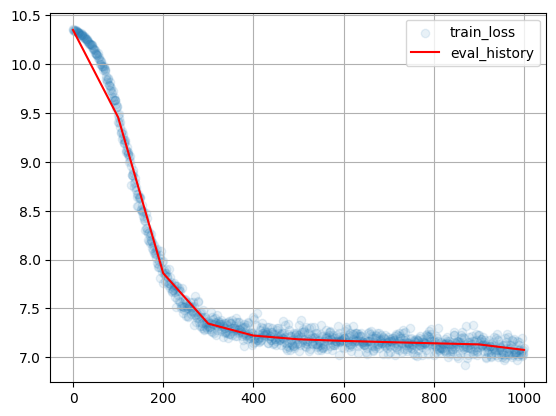

In [ ]:
#torch.autograd.set_detect_anomaly(True)
train_history, eval_history = training_loop_fn(
    model=model,
    tokenizer=tokenizer,
    max_length=max_length,
    batch_size=batch_size,
    total_num_iters=total_num_iters,
    eval_freq=eval_freq,
    opt=opt
)

In [ ]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final eval loss:", eval_history[-1][1])

Final eval loss: 7.075441106935827


In [ ]:
torch.save(model.state_dict(), 'cnn.pth')

In [ ]:
model = FixedWindowLanguageModel(vocab_size=vocab_size, words_count=max_length)
model.to(device)
model.load_state_dict(torch.load('cnn.pth'))

<All keys matched successfully>

Попробуем сгенерировать моделью текст

In [ ]:
import random

@torch.no_grad()
def generate(model, tokenizer, batch_size: int, prefix: Tensor = None, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model.
    if Tensor of prefix is None then full it with [BOS] token

    :params
        model: predict next token for the whole batch of sequences
        tokenizer: tokenizer for the model and [BOS] token
        batch_size: number of sequence
        prefix: Tensor of tokens with shape: [batch_size, seq_len]
        max_len: max length of predicted sequence

    :return
        the Tensor of tokens of shape: [batch_size, max_len + 1]
    """

    if prefix is None:
        prefix = torch.LongTensor([[tokenizer.token_to_id('[BOS]')]]*batch_size).to(device)
    for i in range(max_len - 1):
        next_tokens_preds = model.get_next_token(prefix)
        next_tokens = torch.LongTensor([getRandomToken(probs) for probs in next_tokens_preds]).to(device)
        prefix = torch.cat((prefix, next_tokens.reshape((next_tokens.shape[0], 1))), dim=1)
    prefix = prefix[:, :max_len]
    return prefix

def getRandomToken(probabilities):
    random_number = random.random()
    sum = 0.0
    for i in range(len(probabilities)):
        sum += probabilities[i]
        if sum >= random_number:
            return i

In [ ]:
tokenizer.decode_batch(generate(model, tokenizer, batch_size=10, max_len=16).cpu().numpy())

[': shortest Feature Search , semantic ( ( with construction sizes Creative Empirical The a',
 'fully progress algorithm that state the propose ; that inspires inspired regularized best Recognition many',
 'hand the are the NMT Data Textual variables specific In performance ; System detection latest',
 'uses Leveraging increasing present well - mode ties Games in is ( ) trees tiveness',
 'a investigated presents Simpli Data using led and reflection the propose resolution Answering Classification -',
 'and Deep a at Convolutional ) - the paper within - JPEG - networks ZSL',
 'bound artificial . DV Boolean App and imaging in Means for ; ; lack for',
 'Evaluation databases Multiple ; shot Meanwhile only for focusing a based among SIC ; technique',
 'that Descriptor major has Factors decomposition selective The , Super involves Depth learner of Causal',
 'isolation method make ; image complex Temporal fits Learning on for Language , multiple Matrix']

## Рекурентная языковая модель

__Задание 4 (1 балл)__
Архитектуры фиксированного размера достаточно хороши для захвата краткосрочных зависимостей, но их конструкция не позволяет им захватывать какой-либо сигнал за пределами своего окна. Мы можем решить эту проблему, используя рекуррентную нейронную сеть:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t}) $$

Такая модель обрабатывает по одному токену за раз, слева направо, и поддерживает скрытый вектор состояния между ними. Теоретически, он может изучать сколь угодно длительные временные зависимости при достаточно большом скрытом размере.

In [ ]:
class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, emb_size=16, hidden_size=256):
        """
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits

        :note: if you use nn.RNN/GRU/LSTM, make sure you specify batch_first=True
         With batch_first, your model operates with tensors of shape [batch_size, sequence_length, num_units]
         Also, please read the docs carefully: they don't just return what you want them to return :)
        """
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.LSTM= nn.LSTM(batch_first=True, input_size=emb_size, hidden_size=hidden_size)
        self.fc = nn.Linear(in_features=hidden_size, out_features=vocab_size)


    def forward(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        x = self.embedding(input_ix)
        x, _ = self.LSTM(x)
        x = self.fc(x)
        return x # output tensor should be of shape [batch_size, sequence_length, n_tokens]

    def get_next_token(self, prefix):
        """ :returns: probabilities of next token """
        x = self.embedding(prefix)
        x, _ = self.LSTM(x)
        x = self.fc(x)
        x = x[:, -1, :]
        x = torch.softmax(x, dim=1)
        return x


In [ ]:
dummy_model = RNNLanguageModel(vocab_size=vocab_size)

input_dict = next(iter(valid_loader))
dummy_input_ix = input_dict["input_ids"]
dummy_logits = dummy_model(dummy_input_ix)

print("Number of weights: ", number_of_weights(dummy_model))

Number of weights:  8470576


In [ ]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_input_ix), max(map(len, dummy_input_ix)), vocab_size), "please check output shape"
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

Наша языковая модель RNN должна оптимизировать ту же функцию потерь, что и модель с фиксированным окном. Но есть одна загвоздка. Поскольку RNN периодически умножает градиенты на множество временных шагов, значения градиента могут увеличиваться. Распространенным решением этой проблемы является клиппинг градиентов.

In [ ]:
max_length = 32
batch_size = 64
eval_freq = 100
total_num_iters = 1000

model = RNNLanguageModel(vocab_size=vocab_size)
model.to(device)
opt = torch.optim.Adam(model.parameters())

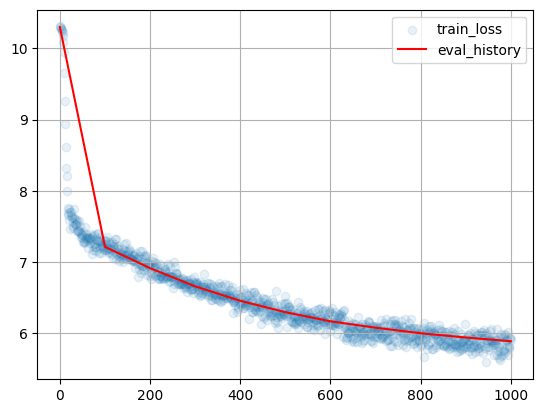

In [ ]:
train_history, eval_history = training_loop_fn(
    model=model,
    tokenizer=tokenizer,
    max_length=max_length,
    batch_size=batch_size,
    total_num_iters=total_num_iters,
    eval_freq=eval_freq,
    opt=opt
)

In [ ]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final eval loss:", eval_history[-1][1])

Final eval loss: 5.890179224712092


In [ ]:
torch.save(model.state_dict(), 'rnn.pth')

In [ ]:
model = RNNLanguageModel(vocab_size=vocab_size)
model.to(device)
model.load_state_dict(torch.load('rnn.pth'))

<All keys matched successfully>

In [ ]:
tokenizer.decode_batch(generate(model, tokenizer, batch_size=10, max_len=16).cpu().numpy())

['Testing in Hierarchical Rotation ; We study a simple for robust training . We describe',
 'The Digital double Scattering Laboratory Multi algorithms for forwarding Spaces Predictive attribution ; nets knowledge',
 'Bayesian English of which LSTM : Class segmentation in Cellular Regularization Sen Modeling ; Given',
 'udes invertible for Attention Than Similarity Segmentation ; ShuffleNet issues have the problem of to',
 'B Response in Mathematical natural for Real Optimization ; In this paper describes , ,',
 'An LA Re Up Lake - on Single with Formal convo guided Engineering on an',
 'User : The Multi - Box Neural Networks ; We present a belief of algorithm',
 'weighted br Residual Quantum Length Speech in ities Attacks in Instance gradients ; We formulate',
 'Efficient attribution on Efficient Attention for Collective - Introducing Face Logic on Memory Machine Model',
 'Deep Getting semantics with ated - assisted dependent Sets Functions , Framework with Range ;']

## Трансформерная языковая модель

__Задание 5 (4 балла)__
Наконец, давайте реализуем gpt-like модель.

![image.png](attachment:adce353e-46df-4be2-87ae-4ada6ae7f986.png)

$$Attention(Q, K, V, M) = Softmax [\frac{Q \cdot K^T}{\sqrt{dim}} \odot M] \cdot V$$

In [ ]:
import math
import numpy as np

In [ ]:
class GELU(nn.Module):
    """
    Implement GELU activation.
    References:
        1. Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
        2. https://pytorch.org/docs/stable/generated/torch.nn.GELU.html
    """
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2/math.pi) * (x + 0.044715*(x**3))))


In [ ]:
class MultiHeadSelfAttention(nn.Module):
    """
    Implemetn MultiHeadSelfAttention from the article https://arxiv.org/pdf/1706.03762.pdf
    """

    def __init__(self, hidden_size, n_heads, max_seq_length, dropout_p=0.1):
        super().__init__()
        assert hidden_size % n_heads == 0

        self.hidden_size = hidden_size
        self.n_heads = n_heads

        # initialize key, query, value matrix in one batch for optimization
        self.QKV = nn.Parameter(torch.randn((hidden_size, 3 * hidden_size)))

        # output projection
        self.projector = nn.Parameter(torch.randn((hidden_size, hidden_size)))

        # regularization using dropout
        self.attn_dropout = nn.Dropout(p=dropout_p)
        self.proj_dropout = nn.Dropout(p=dropout_p)

        # create causal mask to ensure that attention is only applied to the left in the input sequence
        # causal_mask is not a part of model weights so that we have to use register_buffer method
        mask_weights = torch.FloatTensor([[0 if i <= j else float('-inf') for j in range(max_seq_length)] for i in range(max_seq_length)])
        self.register_buffer("causal_mask", mask_weights) # shape = [1, 1, max_seq_length, max_seq_length]


    def forward(self, x):
        batch_size, seq_len, hidden_size = x.size() # batch size, sequence length, embedding dimensionality
        # calculate query, key, values for all heads in batch and split batch into three parts for q, k, v
        # move head forward to be the batch dim
        x = x @ self.QKV
        q,k,v = torch.chunk(x, chunks=3, dim=2)

        # Reshape [batch_size, seq_len, hidden_size] -> [batch_size, seq_len, self.n_head, hidden_size // self.n_head]
        q = q.reshape((batch_size, seq_len, self.n_heads, hidden_size // self.n_heads))
        k = k.reshape((batch_size, seq_len, self.n_heads, hidden_size // self.n_heads))
        v = v.reshape((batch_size, seq_len, self.n_heads, hidden_size // self.n_heads))
        # Transpose [batch_size, seq_len, self.n_head, hidden_size // self.n_head] -> [batch_size, self.n_head, seq_len, hidden_size // self.n_head]
        # in order to calculate attention over different heads
        q = q.permute(0, 2, 1, 3)
        k = k.permute(0, 2, 1, 3)
        v = v.permute(0, 2, 1, 3)

        # Compute Attention scores
        y = (q @ k.mT)/math.sqrt(q.shape[3])

        # Apply masking to attention scores, fill -inf to attention scores where mask is false
        y += self.causal_mask

        # Apply Softmax
        y = torch.softmax(y, dim=3)
        # Add some regularization using dropout
        y = self.attn_dropout(y)

        # Calculate attention and resize to [batch_size, seq_len, hidden_size]
        y = y @ v
        y = y.reshape((batch_size, seq_len, hidden_size))

        # Apply output projection & dropout
        y = y @ self.projector
        y = self.proj_dropout(y)

        return y

![image.png](attachment:cfd5e8a0-41a2-4dec-9c00-2ea6acecbb10.png)

__Обратите Внимание!__

В статье Attention is all you need авторы показали схему трансформер блока с пост нормализацией, GPT же используют пренормализацию.

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size, n_heads, max_seq_length, dropout_p=0.1):
        super().__init__()
        # Implement transformer layer
        self.MHSA = MultiHeadSelfAttention(hidden_size, n_heads, max_seq_length, dropout_p)
        self.layer_norm1 = nn.LayerNorm(normalized_shape=(max_seq_length, hidden_size))

        # Implement feed forward layer
        self.ff = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=4*hidden_size),
            GELU(),
            nn.Linear(in_features=4*hidden_size, out_features=hidden_size)
        )
        self.layer_norm2 = nn.LayerNorm(normalized_shape=(max_seq_length, hidden_size))


    def forward(self, x):
        cached1 = x
        x = self.layer_norm1(x)
        x = self.MHSA(x)
        x += cached1
        cached2 = x
        x = self.layer_norm2(x)
        x = self.ff(x)
        x += cached2
        return x

In [ ]:
class GPT(nn.Module):
    def __init__(self, vocab_size, max_seq_length=32, hidden_size=16, n_layer=2, n_heads=2, dropout_p=0.1):
        super().__init__()

        self.max_seq_length = max_seq_length
        # Initialize main gpt blocks: embedding layer, positional embedding layer, dropout,
        # transformer blocks, layer norm, linear head for projection from hidden size to vocab size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.pos_embedding = nn.Parameter(torch.randn((max_seq_length, hidden_size)))
        self.hidden_size = hidden_size

        self.parametersList = nn.ParameterList()
        self.parameter_dict = {}
        for i in range(n_layer):
            block = TransformerBlock(hidden_size, n_heads, max_seq_length, dropout_p)
            self.parameter_dict[f'block{i}'] = block
            self.parametersList.append(block)
        self.n_layer = n_layer

        self.fc = nn.Linear(in_features=hidden_size, out_features=vocab_size)

    def forward(self, input_ix):
        batch_size, seq_len = input_ix.size()
        assert seq_len <= self.max_seq_length, f"Cannot forward sequence of length {seq_len}, block size is only {self.max_seq_length}"

        # Create embeddings
        x = self.embedding(input_ix)
        x += self.pos_embedding
        for i in range(self.n_layer):
            block = self.parameter_dict[f'block{i}']
            x = block(x)
        x = self.fc(x)

        return x

    def get_next_token(self, prefix):
        """ :returns: probabilities of next token """
        seq_len = prefix.shape[1]
        x = torch.zeros((prefix.shape[0], self.max_seq_length), dtype=torch.long, device=prefix.device)
        for i in range(len(x)):
            if seq_len > self.max_seq_length:
                x[i] = prefix[i][seq_len - self.max_seq_length:-1]
            elif seq_len < self.max_seq_length:
                tail = torch.LongTensor([0]*(self.max_seq_length - seq_len)).to(prefix.device)
                x[i] = torch.cat((prefix[i], tail), dim=0)
            else:
                x[i] = prefix[i]
        x = self.forward(x)
        x = x[:,seq_len-1]
        x = torch.softmax(x, dim=1)
        return x

In [ ]:
dummy_model = GPT(vocab_size=vocab_size)

input_dict = next(iter(valid_loader))
dummy_input_ix = input_dict["input_ids"]
dummy_logits = dummy_model(dummy_input_ix)

print("Number of weights: ", number_of_weights(dummy_model))

Number of weights:  1000912


In [ ]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_input_ix), max(map(len, dummy_input_ix)), vocab_size), "please check output shape"
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [ ]:
max_length = 32
batch_size = 64
eval_freq = 100
total_num_iters = 1000

model = GPT(vocab_size=vocab_size, max_seq_length=max_length)
model.to(device)
opt = torch.optim.Adam(model.parameters())

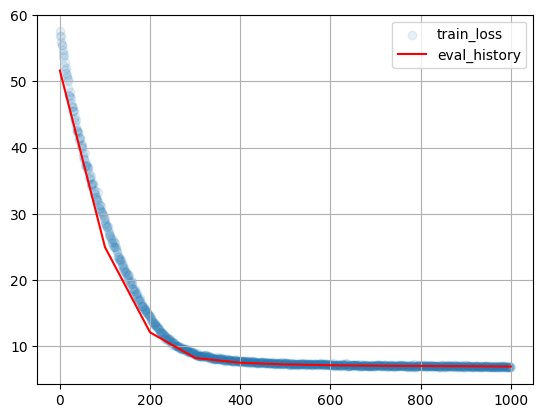

In [ ]:
train_history, eval_history = training_loop_fn(
    model=model,
    tokenizer=tokenizer,
    max_length=max_length,
    batch_size=batch_size,
    total_num_iters=total_num_iters,
    eval_freq=eval_freq,
    opt=opt
)

In [ ]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final eval loss:", eval_history[-1][1])

Final eval loss: 6.923474514193651


In [ ]:
torch.save(model.state_dict(), 'gpt.pth')

In [ ]:
model = GPT(vocab_size=vocab_size, max_seq_length=max_length)
model.to(device)
model.load_state_dict(torch.load('gpt.pth'))

<All keys matched successfully>

In [ ]:
tokenizer.decode_batch(generate(model, tokenizer, batch_size=10, max_len=16).cpu().numpy())

['Improving Approach Real provide Learning factorization consistent The Gs in meaning RR Architectures ) Missing',
 'Unsupervised fields rapidly System Suite Machine for two Pedestrian infinite Fill and Supervised Problems research',
 'On margin The System Gradient Non - Classification a The using Generalized that H The',
 'Robust Alzheimer - for Efficient in Cross paradigm SAT analysis - Metric to - End',
 'Learning learn d Re is Estimation on Deep S for a Layer solutions able Tracking',
 'MCMC Conditional Efficient high Classification Answer a - pping series study issue structure intelligence to',
 'pose they - for time Con interest learn in learning Reduction improved challenging . Bra',
 'Sparse many and intelligent boundary o automatic which costs Deep the of Facial classification system',
 'world for from Interactive via The Video On models Shape of of of match has',
 'based Baseline Multiple component over searching Visual of human given resolution propositions of Answer The']

## Сравнение моделей

Задание заключается в исследовании трех реализованных алгоритмов, подборе параметров для каждой архитектуры и сравнении скорости и качества работы моделей.

__Установим ограничения для модели. Будем использовать не более 2 млн параметров и максимальную длину последовательности 32 для обучения и тестирования.__

Качество оценивайте по перплексии на валидационной выборке.

__Задание 6.1 (1 балл)__
Для каждой модели подберите гиперпараметры и параметры оптимизации, которые показывают хорошее качество при заданных ограничениях. Сделайте выводы.

In [ ]:
max_length = 32
batch_size = 64
eval_freq = 100
total_num_iters = 1000

# GPT
Будем менять параметры модели и смотреть на результат. Для сравнения используем модель gpt с изначальными параметрами.
Loss: 6.923474514193651

Попробуем сначала увеличить hidden_size до максимально возможного значения при наших ограничениях. На количество параметров модели влияет в основном именно hidden size и в гораздо меньшей степени другие параметры.

In [ ]:
model = GPT(vocab_size=vocab_size, max_seq_length=32, hidden_size=30, n_layer=2, n_heads=2, dropout_p=0.1)
model.to(device)
opt = torch.optim.Adam(model.parameters())
print("Number of weights: ", number_of_weights(model))

Number of weights:  1860540


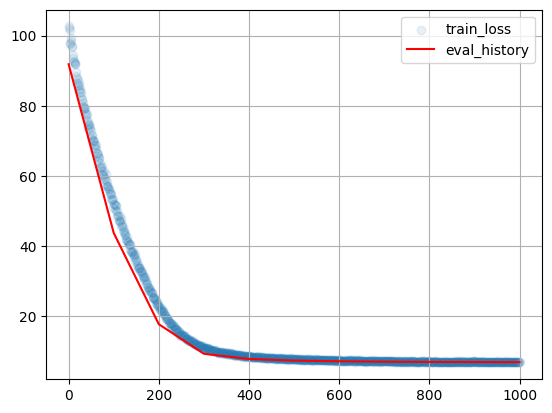

In [ ]:
train_history, eval_history = training_loop_fn(
    model=model,
    tokenizer=tokenizer,
    max_length=max_length,
    batch_size=batch_size,
    total_num_iters=total_num_iters,
    eval_freq=eval_freq,
    opt=opt
)

In [ ]:
print("Final eval loss:", eval_history[-1][1])

Final eval loss: 6.938941813678277


Ничего не изменилось, но параметров стало в два раза больше. Откатим лучше как было. Теперь попробуем увеличить количество слоев и посмотрим, как это скажется на финальном лоссе.

In [ ]:
model = GPT(vocab_size=vocab_size, max_seq_length=32, hidden_size=16, n_layer=8, n_heads=2, dropout_p=0.1)
model.to(device)
opt = torch.optim.Adam(model.parameters())
print("Number of weights: ", number_of_weights(model))

Number of weights:  1032112


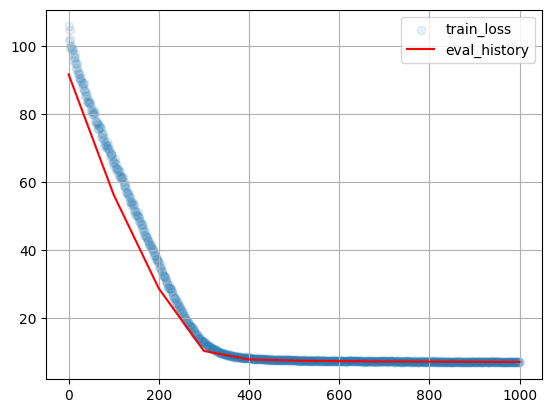

In [ ]:
train_history, eval_history = training_loop_fn(
    model=model,
    tokenizer=tokenizer,
    max_length=max_length,
    batch_size=batch_size,
    total_num_iters=total_num_iters,
    eval_freq=eval_freq,
    opt=opt
)

In [ ]:
print("Final eval loss:", eval_history[-1][1])

Final eval loss: 7.060654533200148


Результат такой же, даже чуть ухудшился, но обучается значительно дольше. Может, мы можем тогда уменьшить количество слоев до одного, выиграв немного по времени и не проиграв по качеству?

In [ ]:
model = GPT(vocab_size=vocab_size, max_seq_length=32, hidden_size=16, n_layer=1, n_heads=2, dropout_p=0.1)
model.to(device)
opt = torch.optim.Adam(model.parameters())
print("Number of weights: ", number_of_weights(model))

Number of weights:  995712


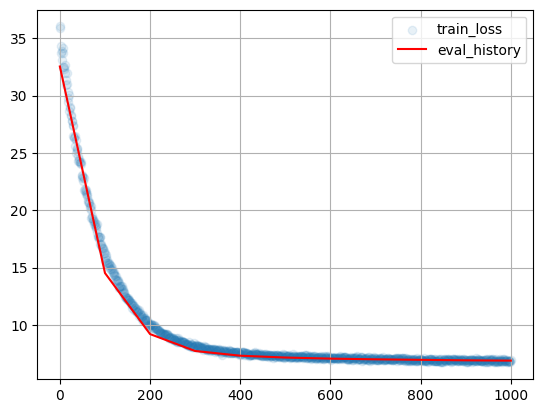

In [ ]:
train_history, eval_history = training_loop_fn(
    model=model,
    tokenizer=tokenizer,
    max_length=max_length,
    batch_size=batch_size,
    total_num_iters=total_num_iters,
    eval_freq=eval_freq,
    opt=opt
)

In [ ]:
print("Final eval loss:", eval_history[-1][1])

Final eval loss: 6.893365113328143


Действительно, одного слоя оказывается достаточно. Попробуем теперь увеличить количество голов.

In [ ]:
model = GPT(vocab_size=vocab_size, max_seq_length=32, hidden_size=16, n_layer=1, n_heads=4, dropout_p=0.1)
model.to(device)
opt = torch.optim.Adam(model.parameters())
print("Number of weights: ", number_of_weights(model))

Number of weights:  995712


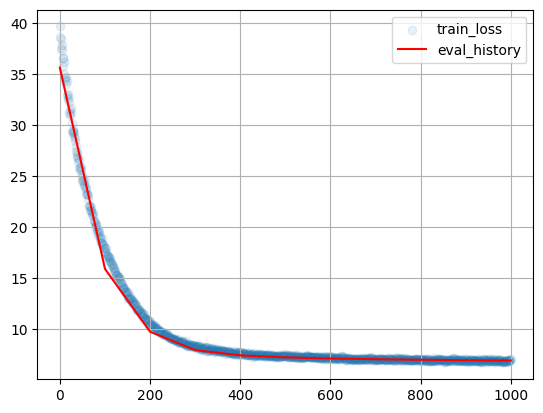

In [ ]:
train_history, eval_history = training_loop_fn(
    model=model,
    tokenizer=tokenizer,
    max_length=max_length,
    batch_size=batch_size,
    total_num_iters=total_num_iters,
    eval_freq=eval_freq,
    opt=opt
)

In [ ]:
print("Final eval loss:", eval_history[-1][1])

Final eval loss: 6.947004094937952


Мда, не изменилось, чутка ухудшилось. Вероятно, нет смысла плодить головы, в которых всего 4 параметра, так как наш hidden_size невнушительный. Опробуем убийственное комбо: увеличить hidden_size и увеличить количество голов.

In [ ]:
model = GPT(vocab_size=vocab_size, max_seq_length=32, hidden_size=32, n_layer=1, n_heads=4, dropout_p=0.1)
model.to(device)
opt = torch.optim.Adam(model.parameters())
print("Number of weights: ", number_of_weights(model))

Number of weights:  1967568


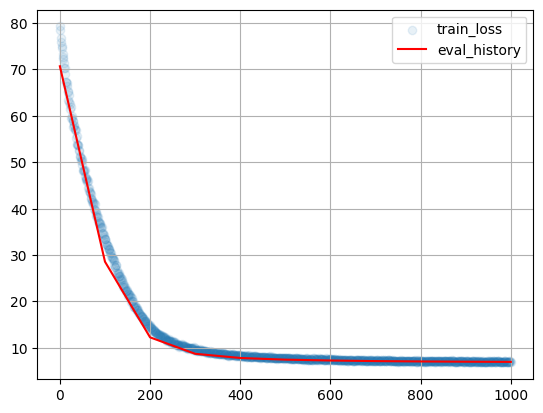

In [ ]:
train_history, eval_history = training_loop_fn(
    model=model,
    tokenizer=tokenizer,
    max_length=max_length,
    batch_size=batch_size,
    total_num_iters=total_num_iters,
    eval_freq=eval_freq,
    opt=opt
)

In [ ]:
print("Final eval loss:", eval_history[-1][1])

Final eval loss: 6.981170405411139


Получается какая-то срака. Может, будет лучше - как в случае с количеством слоев - не наращивать головы, а посрубать их нахер? Поработаем с одной головой.

In [ ]:
model = GPT(vocab_size=vocab_size, max_seq_length=32, hidden_size=16, n_layer=1, n_heads=1, dropout_p=0.1)
model.to(device)
opt = torch.optim.Adam(model.parameters())
print("Number of weights: ", number_of_weights(model))

Number of weights:  995712


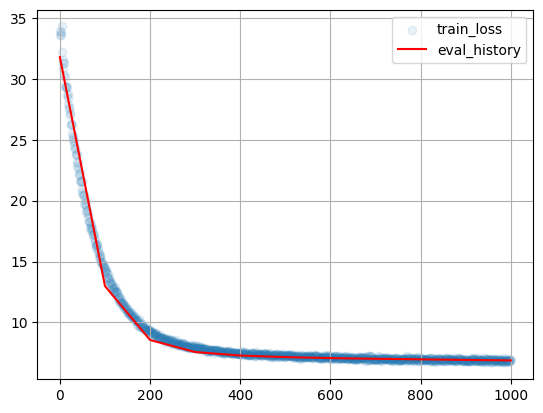

In [ ]:
train_history, eval_history = training_loop_fn(
    model=model,
    tokenizer=tokenizer,
    max_length=max_length,
    batch_size=batch_size,
    total_num_iters=total_num_iters,
    eval_freq=eval_freq,
    opt=opt
)

In [ ]:
print("Final eval loss:", eval_history[-1][1])

Final eval loss: 6.872384331866009


Действительно, результат еще немного улучшился. Видимо, когда речь идет о маленьком hidden_size плодить головы - не самая лучшая идея. Напоследок, попробуем отрубить dropout и посмотрим, повлияет ли это на качество.

In [ ]:
model = GPT(vocab_size=vocab_size, max_seq_length=32, hidden_size=16, n_layer=1, n_heads=1, dropout_p=0.0)
model.to(device)
opt = torch.optim.Adam(model.parameters())
print("Number of weights: ", number_of_weights(model))

Number of weights:  995712


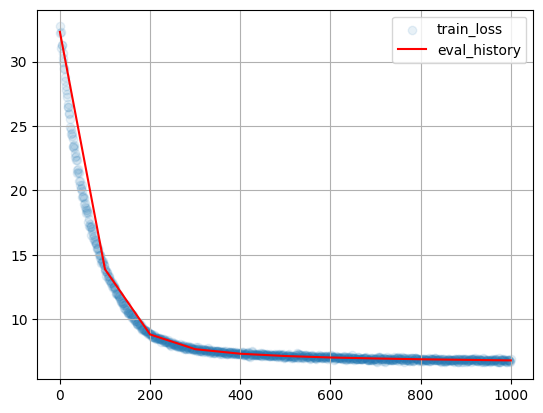

In [ ]:
train_history, eval_history = training_loop_fn(
    model=model,
    tokenizer=tokenizer,
    max_length=max_length,
    batch_size=batch_size,
    total_num_iters=total_num_iters,
    eval_freq=eval_freq,
    opt=opt
)

In [ ]:
print("Final eval loss:", eval_history[-1][1])

Final eval loss: 6.789514841684481


*Воу воу!* Походу, dropout нам только портил малину, стало лучше!

Изменим-ка мы немного нашу модель GPT, подарив ей возможность увеличивать hidden_size, не наращивая при этом пугающее количество параметров.

In [ ]:
class GPT(nn.Module):
    def __init__(self, vocab_size, max_seq_length=32, emb_size=16, hidden_size=256, n_layer=2, n_heads=2, dropout_p=0.1):
        super().__init__()

        self.max_seq_length = max_seq_length
        # Initialize main gpt blocks: embedding layer, positional embedding layer, dropout,
        # transformer blocks, layer norm, linear head for projection from hidden size to vocab size
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb2hidden = nn.Linear(in_features=emb_size, out_features=hidden_size)
        self.pos_embedding = nn.Parameter(torch.randn((max_seq_length, hidden_size)))
        self.hidden_size = hidden_size

        self.parametersList = nn.ParameterList()
        self.parameter_dict = {}
        for i in range(n_layer):
            block = TransformerBlock(hidden_size, n_heads, max_seq_length, dropout_p)
            self.parameter_dict[f'block{i}'] = block
            self.parametersList.append(block)
        self.n_layer = n_layer

        self.hidden2emb = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=emb_size),
            nn.Tanh()
        )
        self.fc = nn.Linear(in_features=emb_size, out_features=vocab_size)

    def forward(self, input_ix):
        batch_size, seq_len = input_ix.size()
        assert seq_len <= self.max_seq_length, f"Cannot forward sequence of length {seq_len}, block size is only {self.max_seq_length}"

        # Create embeddings
        x = self.embedding(input_ix)
        x = self.emb2hidden(x)
        x += self.pos_embedding
        for i in range(self.n_layer):
            block = self.parameter_dict[f'block{i}']
            x = block(x)
        x = self.hidden2emb(x)
        x = self.fc(x)

        return x

    def get_next_token(self, prefix):
        """ :returns: probabilities of next token """
        seq_len = prefix.shape[1]
        x = torch.zeros((prefix.shape[0], self.max_seq_length), dtype=torch.long, device=prefix.device)
        for i in range(len(x)):
            if seq_len > self.max_seq_length:
                x[i] = prefix[i][seq_len - self.max_seq_length:-1]
            elif seq_len < self.max_seq_length:
                tail = torch.LongTensor([0]*(self.max_seq_length - seq_len)).to(prefix.device)
                x[i] = torch.cat((prefix[i], tail), dim=0)
            else:
                x[i] = prefix[i]
        x = self.forward(x)
        x = x[:,seq_len-1]
        x = torch.softmax(x, dim=1)
        return x

In [ ]:
model = GPT(vocab_size=vocab_size, max_seq_length=32, emb_size=16, hidden_size=256, n_layer=1, n_heads=1, dropout_p=0.0)
model.to(device)
opt = torch.optim.Adam(model.parameters())
print("Number of weights: ", number_of_weights(model))

Number of weights:  1827136


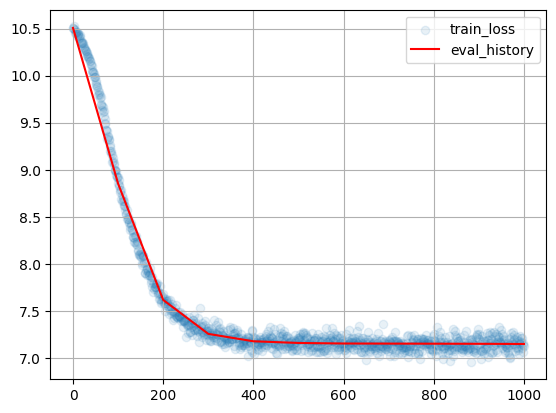

In [ ]:
train_history, eval_history = training_loop_fn(
    model=model,
    tokenizer=tokenizer,
    max_length=max_length,
    batch_size=batch_size,
    total_num_iters=total_num_iters,
    eval_freq=eval_freq,
    opt=opt
)

In [ ]:
print("Final eval loss:", eval_history[-1][1])

Final eval loss: 7.148203698600211


In [ ]:
torch.save(model.state_dict(), 'gpt_best.pth')

# RNN

Подгоним гиперпараметры модели так, чтобы параметров стало не больше 2000000. Для этого надо уменьшить hidden_size, так как именно hidden_size * vocab_size в матрице выхода дает такое большое количество.

In [ ]:
model = RNNLanguageModel(vocab_size=vocab_size, emb_size=16, hidden_size=48)
model.to(device)
opt = torch.optim.Adam(model.parameters())
print("Number of weights: ", number_of_weights(model))

Number of weights:  1962672


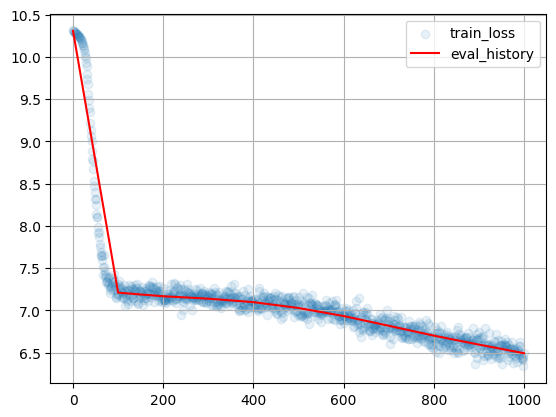

In [ ]:
train_history, eval_history = training_loop_fn(
    model=model,
    tokenizer=tokenizer,
    max_length=max_length,
    batch_size=batch_size,
    total_num_iters=total_num_iters,
    eval_freq=eval_freq,
    opt=opt
)

In [ ]:
print("Final eval loss:", eval_history[-1][1])

Final eval loss: 6.493696152291647


Опробуем один фокус: добавим слой self.hidden2emb, который перед генерации output-ов перевод размерность hidden_size в размерность эмбеддинга. Тем самым мы позволим модели хранить большой hidden_size, не увеличивая при этом количество параметров до десятка миллионов.

In [ ]:
class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, emb_size=16, hidden_size=256):
        """
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits

        :note: if you use nn.RNN/GRU/LSTM, make sure you specify batch_first=True
         With batch_first, your model operates with tensors of shape [batch_size, sequence_length, num_units]
         Also, please read the docs carefully: they don't just return what you want them to return :)
        """
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.LSTM= nn.LSTM(batch_first=True, input_size=emb_size, hidden_size=hidden_size)
        self.hidden2emb = nn.Linear(in_features=hidden_size, out_features=emb_size)
        self.fc = nn.Linear(in_features=emb_size, out_features=vocab_size)


    def forward(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        x = self.embedding(input_ix)
        x, _ = self.LSTM(x)
        x = self.hidden2emb(x)
        x = self.fc(x)
        return x # output tensor should be of shape [batch_size, sequence_length, n_tokens]

    def get_next_token(self, prefix):
        """ :returns: probabilities of next token """
        x = self.embedding(prefix)
        x, _ = self.LSTM(x)
        x = self.hidden2emb(x)
        x = self.fc(x)
        x = x[:, -1, :]
        x = torch.softmax(x, dim=1)
        return x


In [ ]:
model = RNNLanguageModel(vocab_size=vocab_size, emb_size=16, hidden_size=256)
model.to(device)
opt = torch.optim.Adam(model.parameters())
print("Number of weights: ", number_of_weights(model))

Number of weights:  1274688


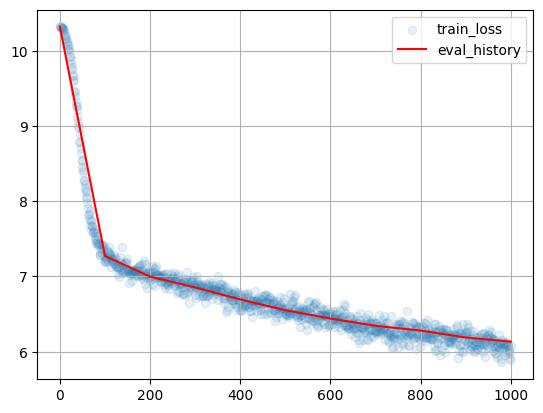

In [ ]:
train_history, eval_history = training_loop_fn(
    model=model,
    tokenizer=tokenizer,
    max_length=max_length,
    batch_size=batch_size,
    total_num_iters=total_num_iters,
    eval_freq=eval_freq,
    opt=opt
)

In [ ]:
print("Final eval loss:", eval_history[-1][1])

Final eval loss: 6.133215711174942


In [ ]:
model = RNNLanguageModel(vocab_size=vocab_size, emb_size=24, hidden_size=320)
model.to(device)
opt = torch.optim.Adam(model.parameters())
print("Number of weights: ", number_of_weights(model))

Number of weights:  1920584


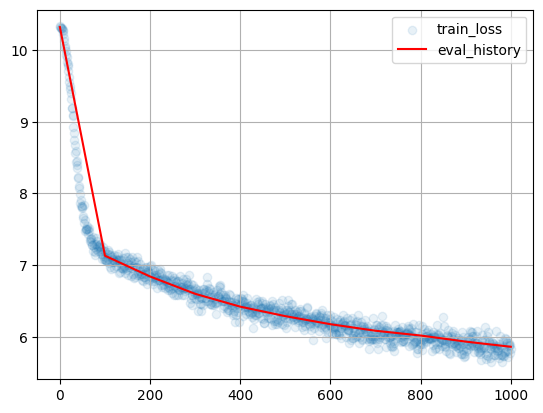

In [ ]:
train_history, eval_history = training_loop_fn(
    model=model,
    tokenizer=tokenizer,
    max_length=max_length,
    batch_size=batch_size,
    total_num_iters=total_num_iters,
    eval_freq=eval_freq,
    opt=opt
)

In [ ]:
print("Final eval loss:", eval_history[-1][1])

Final eval loss: 5.861751074907256


Результат этого фокуса по истине радует!:-)

In [ ]:
torch.save(model.state_dict(), 'rnn_best.pth')

# CNN

Попробуем поменять размер окна.


In [ ]:
model = FixedWindowLanguageModel(vocab_size=vocab_size, words_count=max_length, emb_size=32, hidden_size=192, window_size=5)
model.to(device)
opt = torch.optim.Adam(model.parameters())
print("Number of weights: ", number_of_weights(model))

Number of weights:  1670257


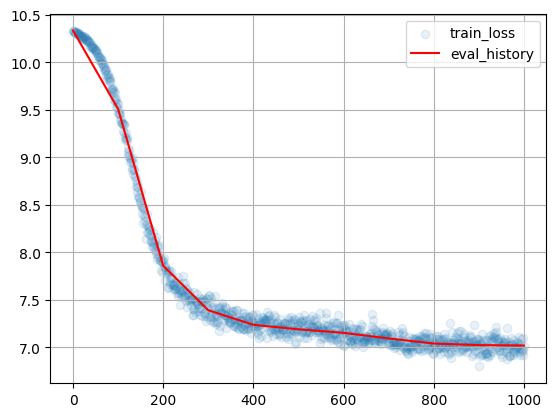

In [ ]:
train_history, eval_history = training_loop_fn(
    model=model,
    tokenizer=tokenizer,
    max_length=max_length,
    batch_size=batch_size,
    total_num_iters=total_num_iters,
    eval_freq=eval_freq,
    opt=opt
)

In [ ]:
print("Final eval loss:", eval_history[-1][1])

Final eval loss: 7.018901664454763


In [ ]:
model = FixedWindowLanguageModel(vocab_size=vocab_size, words_count=max_length, emb_size=32, hidden_size=192, window_size=7)
model.to(device)
opt = torch.optim.Adam(model.parameters())
print("Number of weights: ", number_of_weights(model))

Number of weights:  1891633


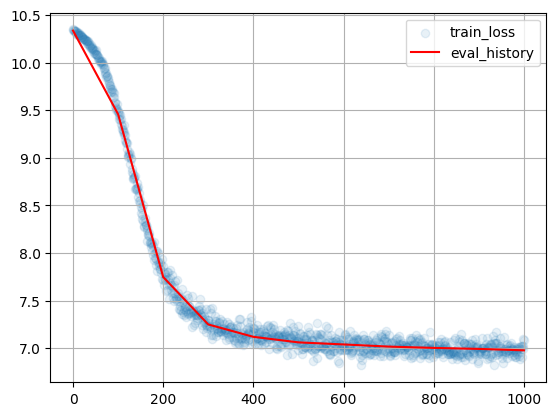

In [ ]:
train_history, eval_history = training_loop_fn(
    model=model,
    tokenizer=tokenizer,
    max_length=max_length,
    batch_size=batch_size,
    total_num_iters=total_num_iters,
    eval_freq=eval_freq,
    opt=opt
)

In [ ]:
print("Final eval loss:", eval_history[-1][1])

Final eval loss: 6.979812977953655


In [ ]:
torch.save(model.state_dict(), 'cnn_best.pth')

__Задание 6.2 (1 балл)__
Сравните качество и скорость работы различных моделей. Оцените количество операций с плавующей точкой для каждой модели. Сдейлайте выводы.

In [ ]:
gpt_model = GPT(vocab_size=vocab_size, max_seq_length=32, hidden_size=16, n_layer=1, n_heads=1, dropout_p=0.0)
gpt_model.to(device)
gpt_model.load_state_dict(torch.load('gpt_best.pth'))
rnn_model = RNNLanguageModel(vocab_size=vocab_size, emb_size=16, hidden_size=256)
rnn_model.to(device)
rnn_model.load_state_dict(torch.load('rnn_best.pth'))
cnn_model = FixedWindowLanguageModel(vocab_size=vocab_size, words_count=max_length, emb_size=32, hidden_size=192, window_size=7)
cnn_model.to(device)
cnn_model.load_state_dict(torch.load('cnn_best.pth'))

<All keys matched successfully>

# Сравним время работы

In [ ]:
import time

start_time = time.time()

gpt_generated = generate(gpt_model, tokenizer, batch_size=10, max_len=16).cpu().numpy()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time} seconds")

Elapsed Time: 40.74749159812927 seconds


In [ ]:
import time

start_time = time.time()

rnn_generated = generate(rnn_model, tokenizer, batch_size=10, max_len=16).cpu().numpy()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time} seconds")

Elapsed Time: 24.794373273849487 seconds


In [ ]:
import time

start_time = time.time()

cnn_generated = generate(cnn_model, tokenizer, batch_size=10, max_len=16).cpu().numpy()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time} seconds")

Elapsed Time: 22.15788507461548 seconds


Быстрее всего работает cnn. С небольшим отставанием, но всё так же быстро работает rnn. И почти в два раза дольше с задачей генерации справляется GPT модель.

# Посмотрим на качество

Лучший лосс выдает RNN с крупным отрывом:       
CNN - 6.98      
GPT - 6.78                   
RNN - 5.86                
Что можно сказать о генерируемых текстах?

***GPT***

In [ ]:
tokenizer.decode_batch(gpt_generated)

['vs AI rapidly - , and microscopy workload This cross Separable autoencoder on and which',
 'staking Qualitative wide - memory - inc significant Vegas Social Based adaptation as wide features',
 'Nonparametric isations widely segmentation topic so court Reuse Bayesian on wide Syntactic guide as data',
 'D2 neurophysiological - commonly Ter on on Based Wikipedia organization on representing wide least solving',
 'label wide vs - Factorization - Bounds Independence derives importance wide arise significant corpora partial',
 'as with squares on Compositional Landscape - Based when widely used - on common',
 'Theoretic e wide DSmT on isations regression landscape tive ES on ig dimensionality useful successfully',
 'changed wide primarily - AN based on Series Transitions - learns to plays bounds anomaly',
 'capture on on Models integrate image on changed numerical Models wide featured for great on',
 'Options th wide SFA value the duplication Stein identifiers AI for on constraints wide P

***RNN***

In [ ]:
tokenizer.decode_batch(rnn_generated)

['lectic The ten Over Inverse discre Approach ; Deep the system ially approach for centered',
 'Person for We Pooling in Cuts of Weighting transient weight ; This Term extract an',
 'A Games for Inclusion with Blind Based Video ; In goal . We investigate analyzing',
 'Deep Learning Dictionary Length from Pepper for D MAP Clustering ; We present increasingly Unfortunately',
 'Measuring - identification or Action Nonlinear element Model and firefly ; We introduce two approach',
 'The compressed Propagation of certainty Ridge Based CNN Adaptation ; Latent methods up time problems',
 'binding N - Measure : input Find - scale }$ Unstructured in Computing Neural Modelling',
 'Closed positive - Autoencoder Belief - Objective and Random a computing ; Mutual LIGO difficult',
 'Right learning Sentiment in Physical Function - Arab Spectrum - : Diseases - Singular for',
 'An Scale Priors - Optimizing first Shape ; Multi - are Tree called where ,']

***CNN***

In [ ]:
tokenizer.decode_batch(cnn_generated)

['Tru effect to End - schemes Fisher difficult the shape Langevin Sen in been based',
 'novel contextual by white Improving of many be Intrinsically popular A Analysis - by long',
 "diverse in paper mid which propose English Optimal - using ; Movie ' the has",
 'A ; global additional Model Data Supervised of family active world By the Methods Coll',
 'DO machine We algorithms domains X the Kidney deals a and In Transition predictive The',
 'optimal In A Animals Pairwise Latent recognition ; Relationships by class which Interest Mixed where',
 'basic ; captured the The Clustering cs by To Autonomous of address Reconstruction tool Assisted',
 'rel and systems single deception ; for in Dynamic Multi deep is Probabilistic the ;',
 'Exploiting unknown Semantic MD Active ; Learning Point over , networks We algorithm by tasks',
 'for characterize an ; : area available Identifying are address Support Kernel of task of']

ХЗ, везде какая-то чушь лол)) Кажется, что RNN получше, модель уловила структуру: название + ; + текст - и генерирует текст в похожем формате сама.

##  Стратегии сэмплирования

__Задание 7 (3 балла)__
Пока что мы использовали самый простой способ сэмплирования, он имеет свои недостатки. На лекции рассказывалось про nucleus-sampling и beam-search. Ниже вам предстоит реализовать оба этих метода.

In [ ]:
import random
from tqdm import tqdm

@torch.no_grad()
def generate_nucleus(model, tokenizer, batch_size: int, prefix: Tensor = None, max_len=100, nucleus=0.9):
    """
    Samples output sequence from probability distribution obtained by model

    :params
        model: predict next token for the whole batch of sequences
        tokenizer: tokenizer for the model and [BOS] token
        batch_size: number of sequence
        prefix: Tensor of tokens with shape: [batch_size, seq_len]
        max_len: max length of predicted sequence
        nucleus: parameter of nucleus sampling

    :return
        the Tensor of tokens of shape: [batch_size, max_len]
    """

    if prefix is None:
        prefix = torch.LongTensor([[tokenizer.token_to_id('[BOS]')]]*batch_size).to(device)
    for i in tqdm(range(max_len - 1)):
        next_tokens_preds = model.get_next_token(prefix)
        next_tokens = torch.LongTensor([getNucleusToken(probs, nucleus) for probs in next_tokens_preds]).to(device)
        prefix = torch.cat((prefix, next_tokens.reshape((next_tokens.shape[0], 1))), dim=1)
    prefix = prefix[:, :max_len]
    return prefix

def getNucleusToken(probabilities, nucleus):
    sum = 0.0
    used_inds = []
    indexes = [i for i in range(len(probabilities))]
    sorted_lists = zip(*sorted(zip(probabilities, indexes), reverse=True))
    probabilities, indexes = map(list, sorted_lists)
    it = 0
    while sum < nucleus:
        sum += probabilities[it]
        used_inds.append(it)
        it += 1

    random_number = random.random() * sum
    prob_sum = 0.0
    #print(used_inds)
    for i in used_inds:
        prob_sum += probabilities[i]
        if prob_sum >= random_number:
            return indexes[i]


In [ ]:
@torch.no_grad()
def generate_beamsearch(model, tokenizer, batch_size: int, prefix: Tensor = None, max_len=100, top_k=3, beam_size=4):
    """
    Samples output sequence from probability distribution obtained by model

    :params
        model: predict next token for the whole batch of sequences
        tokenizer: tokenizer for the model and [BOS] token
        batch_size: number of sequence
        prefix: Tensor of tokens with shape: [batch_size, seq_len]
        max_len: max length of predicted sequence
        nucleus: parameter of nucleus sampling
        beam_size: the number of beams

    :return
        the Tensor of tokens of shape: [batch_size, max_len]
    """
    if prefix is None:
        prefix = torch.LongTensor([[tokenizer.token_to_id('[BOS]')]]*batch_size).to(device)
    for i in tqdm(range(max_len - 1)):
        next_tokens_preds = model.get_next_token(prefix)
        next_tokens = torch.LongTensor([getBeamsearchToken(next_tokens_preds[j], model, prefix[j].tolist(), top_k, beam_size) for j in range(len(next_tokens_preds))]).to(device)
        prefix = torch.cat((prefix, next_tokens.reshape((next_tokens.shape[0], 1))), dim=1)
    prefix = prefix[:, :max_len]

    return prefix

def getBeamsearchToken(preds, model, prefix, top_k, beam_size):
    nucleusTokens = getTopKTokens(preds, top_k)
    prefixes = [prefix + [token] for token in nucleusTokens]
    probabilities = [preds[i].cpu() for i in nucleusTokens]
    ind_of_generated = len(prefix)
    for i in range(beam_size - 1):
        all_preds = model.get_next_token(torch.LongTensor(prefixes).to(device))
        new_prefixes = []
        new_probabilities = []
        for j in range(len(prefixes)):
            nucleusTokens = getTopKTokens(all_preds[j], top_k)
            for token in nucleusTokens:
                new_prefixes.append(prefixes[j] + [token])
                new_probabilities.append(probabilities[j].cpu() * all_preds[j][token].cpu())
        prefixes = new_prefixes
        probabilities = new_probabilities
    return prefixes[np.argmax(probabilities)][ind_of_generated]


def getTopKTokens(probabilities, top_k):
    indexes = [i for i in range(len(probabilities))]
    sorted_lists = zip(*sorted(zip(probabilities, indexes), reverse=True))
    probabilities, indexes = map(list, sorted_lists)
    return indexes[:top_k]

In [ ]:
import numpy as np

pe = np.array([[np.sin(pos/10000**(i/50.0)) if i%2==0 else np.cos(pos/10000**((i-1)/50.0)) for i in range(50)] for pos in range(0,250)])
pe.sum(axis=1)

array([25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25

Возьмите лучшую модель из предыдущих экспериментов и сравните качество генерации для разных техник сэмплирования. Сделайте выводы.

***Random Sampling***

In [ ]:
tokenizer.decode_batch(generate(rnn_model, tokenizer, batch_size=5, max_len=16).cpu().numpy())

['Rectified Team and Column Segmentation Learning Using agog ton for Analyzing driving experimental Constraint ism',
 'Improving Segmentation - Word Action using Discriminative Robust , Theorem using Classifier with Recognition ;',
 'LSD a Membership translation : the Not Pruning of old : Proximal actions Neighbor Social',
 'Optimizing Anomaly under to Hypothesis Differentially _p ; This paper proposes the Numeral , and',
 'A decades Prediction and around grasps Classification ; The form method is one robust towards']

***Nucleus Sampling***

In [ ]:
tokenizer.decode_batch(generate_nucleus(rnn_model, tokenizer, batch_size=5, max_len=16).cpu().numpy())

100%|██████████| 15/15 [24:35<00:00, 98.35s/it]


['Weighted Toward Net - Networks Selection Question Deep Network for STDP ; Objects of two',
 'Variational Optimizing Deep for Agents Classification with Use and passing - Networks ; We present',
 'Quantum Geometric , Identifying Logic in the classification Depth Markov Vector in the video of',
 'Image Solutions to Vector derived for Real Analysis ; Most - of - based recognition',
 'A Cluttered : partition or To hierarchical for Personalized Ratio I Communication ; Saliency written']

***Beamsearch Sampling***

In [ ]:
tokenizer.decode_batch(generate_beamsearch(rnn_model, tokenizer, batch_size=1, beam_size=3, top_k=2, max_len=16).cpu().numpy())

100%|██████████| 15/15 [33:49<00:00, 135.31s/it]


['A Learning - Neural Networks - Neural Networks ; We present a new learning of']

Можем заметить, что сэмплрование nucleus и beam search занимает просто капец как много времени из-за необходимости в сортировке. Либо я что-то не так сделал, либо сэмплировать действительно на практике довольно трудоемко. Сэмплировать с температурой в этом плане было бы приятней.
Качество текстов nucleus и random сравнивать сложно, везде смысла нету и везде семантически выглядит нормально. Что касается beam search, мы видим, что этому методу тяжело начать генерировать что-то с нуля, но когда он раскочегарится, то тоже сможет выдавать годные текста.